<a href="https://colab.research.google.com/github/Nish-hub94/AppliedMLProject/blob/main/AML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import normaltest
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# **Data loading & Data Reading**

In [2]:
df = pd.read_csv('industrial_fault_detection_data_1000.csv', index_col=0, skipinitialspace='True')

# **Data Pre-Processing and Feature Extraction**

In [53]:
### First, We should get an idea about the Data and their relationship ###

print(df.shape)
print(df.duplicated().any()) # Duplicate value check
print(df.isnull().values.any()) # Null Value Check  # No Null values are available.  
print(df.columns)
print(df.head())
df.describe()


(1000, 7)
False
False
Index(['Vibration (mm/s)', 'Temperature (°C)', 'Pressure (bar)',
       'RMS Vibration', 'Mean Temp', 'Fault Label', 'Fault Type'],
      dtype='object')
                     Vibration (mm/s)  Temperature (°C)  Pressure (bar)  \
Timestamp                                                                 
2023-03-10 00:00:00          0.437086         64.810634        7.785117   
2023-03-10 00:01:00          0.955643         93.352076        7.740936   
2023-03-10 00:02:00          0.758795        119.835667        9.718764   
2023-03-10 00:03:00          0.638793        108.577991        7.748639   
2023-03-10 00:04:00          0.240417        114.524892        7.815849   

                     RMS Vibration  Mean Temp  Fault Label     Fault Type  
Timestamp                                                                  
2023-03-10 00:00:00       0.601657  90.561384            1  Bearing Fault  
2023-03-10 00:01:00       0.601657  90.561384            1  Bearing Fa

,Vibration (mm/s),Temperature (°C),Pressure (bar),RMS Vibration,Mean Temp,Fault Label
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000
mean,0.541231,90.561384,8.507217,6.016565e-01,9.056138e+01,0.479000
std,0.262924,23.375191,0.872023,1.110779e-14,7.108983e-13,0.652675
min,0.104169,50.257461,7.000035,6.016565e-01,9.056138e+01,0.000000
25%,0.312376,69.285942,7.784053,6.016565e-01,9.056138e+01,0.000000
50%,0.547127,91.498713,8.501842,6.016565e-01,9.056138e+01,0.000000
75%,0.769888,110.837205,9.277311,6.016565e-01,9.056138e+01,1.000000
max,0.999746,129.953098,9.993463,6.016565e-01,9.056138e+01,2.000000


In [26]:
# Map numeric labels to descriptive names
label_mapping = {0: 'No Fault', 1: 'Bearing Fault', 2: 'Overheating'}
df['Fault Type'] = df['Fault Label'].map(label_mapping)

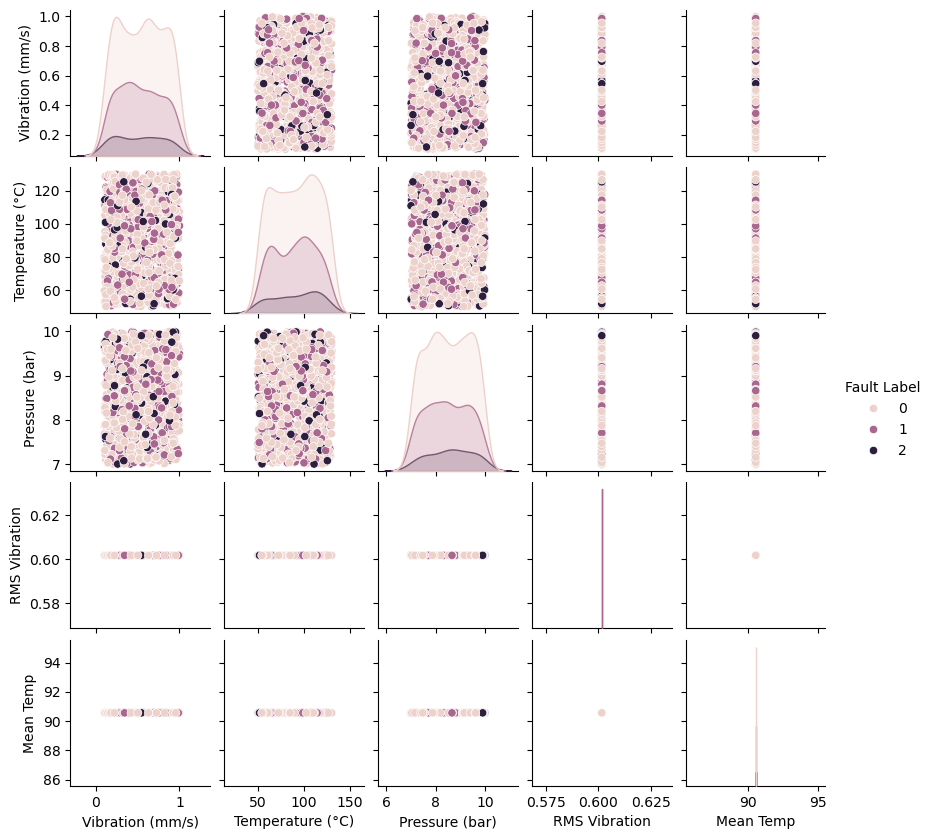

In [6]:
feature_cols = ['Vibration (mm/s)', 'Temperature (°C)', 'Pressure (bar)', 'RMS Vibration', 'Mean Temp']
pair_df = df[feature_cols + ['Fault Label']]

Features= ['Vibration (mm/s)', 'Temperature (°C)', 'Pressure (bar)']
pair_df2 = df[Features + ['Fault Label']]

sns.pairplot(pair_df, hue='Fault Label',diag_kind='kde', height=1.7)

plt.show()  

## According to the Pairplot, Vibration Temporature and Pressure will be taken as training features,
## because These three show clear separation between fault classes (0, 1, 2).

### According to the Pairplot, Vibration Temporature and Pressure will be taken as training features, because These three show clear separation between fault classes (0, 1, 2).

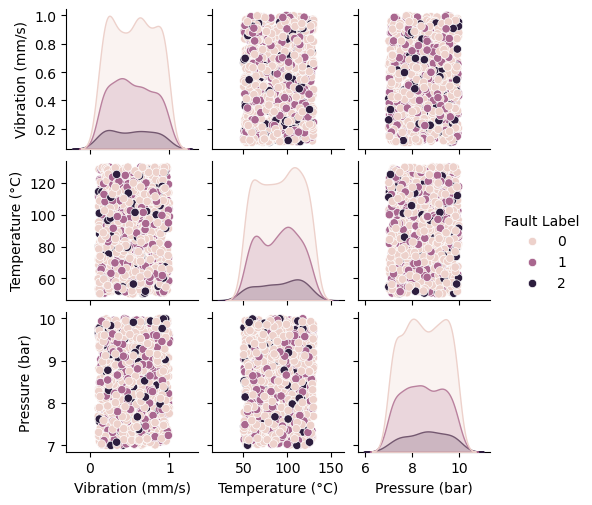

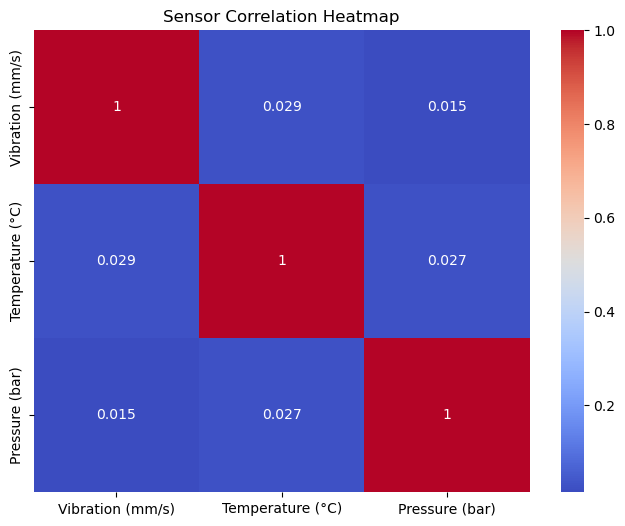

In [ ]:
# Feature Extraction
sns.pairplot(pair_df2, hue='Fault Label',diag_kind='kde', height=1.7)

plt.show()  

# Graph 1 – Sensor Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[['Vibration (mm/s)', 'Temperature (°C)', 'Pressure (bar)']].corr(), annot=True, cmap='coolwarm')
plt.title('Sensor Correlation Heatmap')
plt.show()

Data Imbalance = Fault Label
0    60.9
1    30.3
2     8.8
Name: proportion, dtype: float64


C:\Users\Lakshan Siriwardhana\AppData\Local\Temp\ipykernel_29900\3225298581.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data= df, x='Fault Type', palette='coolwarm')


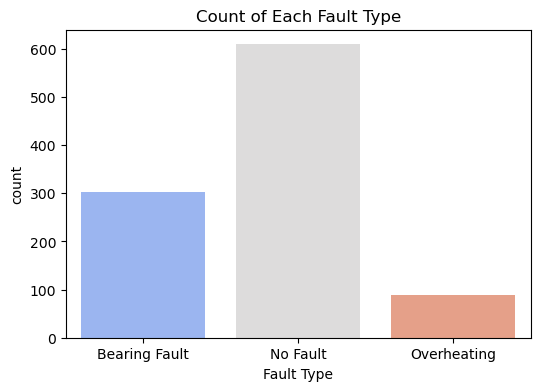

,Vibration (mm/s),Temperature (°C),Pressure (bar),RMS Vibration,Mean Temp,Fault Label,Fault Type
Timestamp,,,,,,,
2023-03-10 00:00:00,0.437086,64.810634,7.785117,0.601657,90.561384,1,Bearing Fault
2023-03-10 00:01:00,0.955643,93.352076,7.740936,0.601657,90.561384,1,Bearing Fault
2023-03-10 00:02:00,0.758795,119.835667,9.718764,0.601657,90.561384,0,No Fault
2023-03-10 00:03:00,0.638793,108.577991,7.748639,0.601657,90.561384,1,Bearing Fault
2023-03-10 00:04:00,0.240417,114.524892,7.815849,0.601657,90.561384,0,No Fault
...,...,...,...,...,...,...,...
2023-03-10 16:35:00,0.182424,102.556413,9.595887,0.601657,90.561384,0,No Fault
2023-03-10 16:36:00,0.925582,126.529170,7.471820,0.601657,90.561384,0,No Fault
2023-03-10 16:37:00,0.223137,55.516641,7.929364,0.601657,90.561384,0,No Fault


In [28]:
# Check Data imbalance
counts = pair_df2['Fault Label'].value_counts(normalize=True) * 100
print("Data Imbalance =", counts) # This means the data is highly imbalanced (60/30/8).

# Plot Example output 
plt.figure(figsize=(6,4))
sns.countplot(data= df, x='Fault Type', palette='coolwarm')
plt.title('Count of Each Fault Type')
plt.show()

df

In [46]:
## Quantitative analysis
## Mean
print("Mean \n", df.groupby('Fault Type').mean())
## Standard Deviation
print("Standard Deviation \n" , df.groupby('Fault Type').std())

Mean 
                Vibration (mm/s)  Temperature (°C)  Pressure (bar)  \
Fault Type                                                          
Bearing Fault          0.534695         89.926908        8.473219   
No Fault               0.547332         90.816609        8.511601   
Overheating            0.521509         90.979731        8.593941   

               RMS Vibration  Mean Temp  Fault Label  
Fault Type                                            
Bearing Fault       0.601657  90.561384          1.0  
No Fault            0.601657  90.561384          0.0  
Overheating         0.601657  90.561384          2.0  
Standard Deviation 
                Vibration (mm/s)  Temperature (°C)  Pressure (bar)  \
Fault Type                                                          
Bearing Fault          0.256694         22.436700        0.867289   
No Fault               0.264925         23.724543        0.873834   
Overheating            0.271606         24.314152        0.878983   

     

In [47]:
# Hypothesis Test was performed to test whether the data were normally distributed or not.
normaltest
print(normaltest(df['Vibration (mm/s)']))
alpha =0.5
statistic, pvalue = normaltest(df['Vibration (mm/s)'])

if pvalue<alpha:
    print('Data is not normally distributed')
else:
    print('Data is not distributed')

NormaltestResult(statistic=np.float64(942.0543911213797), pvalue=np.float64(2.7257633111921575e-205))
Data is not normally distributed


### Since the Data is not normally distributed. We need to use non-parametric tests or transform the data

In [12]:
# Mann-Whitney rank-test 
# Groups
g1 = df[df["Fault Label"] == 0]["Pressure (bar)"]
g2 = df[df["Fault Label"] != 0]["Pressure (bar)"]

# Mann-Whitney U-test (non-parametric)
stat, p_value = mannwhitneyu(g1, g2, alternative="two-sided")

print("U-statistic:", stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("Significant difference between groups.")
else:
    print("No significant difference between groups.")

#-------------------------------------------------------------
# Groups
g1 = df[df["Fault Label"] == 0]["Temperature (°C)"]
g2 = df[df["Fault Label"] != 0]["Temperature (°C)"]

# Mann-Whitney U-test (non-parametric)
stat, p_value = mannwhitneyu(g1, g2, alternative="two-sided")

print("U-statistic:", stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("Significant difference between groups.")
else:
    print("No significant difference between groups.")
#-------------------------------------------------------------
# Groups
g1 = df[df["Fault Label"] == 0]["Vibration (mm/s)"]
g2 = df[df["Fault Label"] != 0]["Vibration (mm/s)"]

# Mann-Whitney U-test (non-parametric)
stat, p_value = mannwhitneyu(g1, g2, alternative="two-sided")

print("U-statistic:", stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("Significant difference between groups.")
else:
    print("No significant difference between groups.")

U-statistic: 119977.0
p-value: 0.8369839602506899
No significant difference between groups.
U-statistic: 121144.0
p-value: 0.6400708409635044
No significant difference between groups.
U-statistic: 123204.0
p-value: 0.352467146883903
No significant difference between groups.


# **Preprocessing**

Seperating features and labels

In [13]:
X = df[Features].values
y = df['Fault Label'].values

In [14]:
print(X)

[[  0.43708611  64.81063431   7.78511705]
 [  0.95564288  93.35207579   7.7409364 ]
 [  0.75879455 119.83566687   9.71876374]
 ...
 [  0.22313677  55.51664131   7.92936358]
 [  0.95521362  54.56437769   7.8701366 ]
 [  0.5014052   72.57496598   9.6142421 ]]


In [15]:
print(y)

[1 1 0 1 0 1 2 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 2 1 1 1 0 0 1 0 0 0 0
 2 0 0 0 2 0 0 1 1 0 0 0 0 0 0 0 0 1 2 1 0 0 2 0 0 0 1 1 0 0 2 0 1 1 1 0 0
 0 1 2 0 0 2 1 1 0 0 1 1 0 0 0 0 0 2 0 1 0 1 2 0 0 0 0 1 2 0 0 0 1 0 0 1 1
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 2 1 1 1 2 0 0 1 1 1 0 0 0 2 0 0 0 0 1 1
 1 0 1 0 1 0 0 1 2 0 1 0 0 0 0 0 0 0 2 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 2 2 0 0 0 2 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 2 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0
 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1 2 0 0 1 0 0 2 0
 1 0 0 1 0 2 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0
 0 1 1 2 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 2 0 0 0 1 0 1 1 1 0 1 0 2 1 0 0 0 1
 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 2 2 1 1 0 0 0 0 2 0 1 1 1
 2 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 0 2 1 0 1 0 0 0 2 2 0 0 0 2
 2 1 1 1 0 0 0 1 1 0 2 0 0 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 2 0 0 0 0
 0 0 2 0 0 0 0 0 0 0 1 1 

In [16]:
# === Map labels (for interpretability in plots/reports) ===
label_mapping = {0: 'No Fault', 1: 'Bearing Fault', 2: 'Overheating'}
df['Fault Type'] = df['Fault Label'].map(label_mapping)

**Split first (to prevent data leakage)**

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [18]:
pca= PCA(n_components=2)
X_pca = pca.fit_transform(X)    
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)   
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


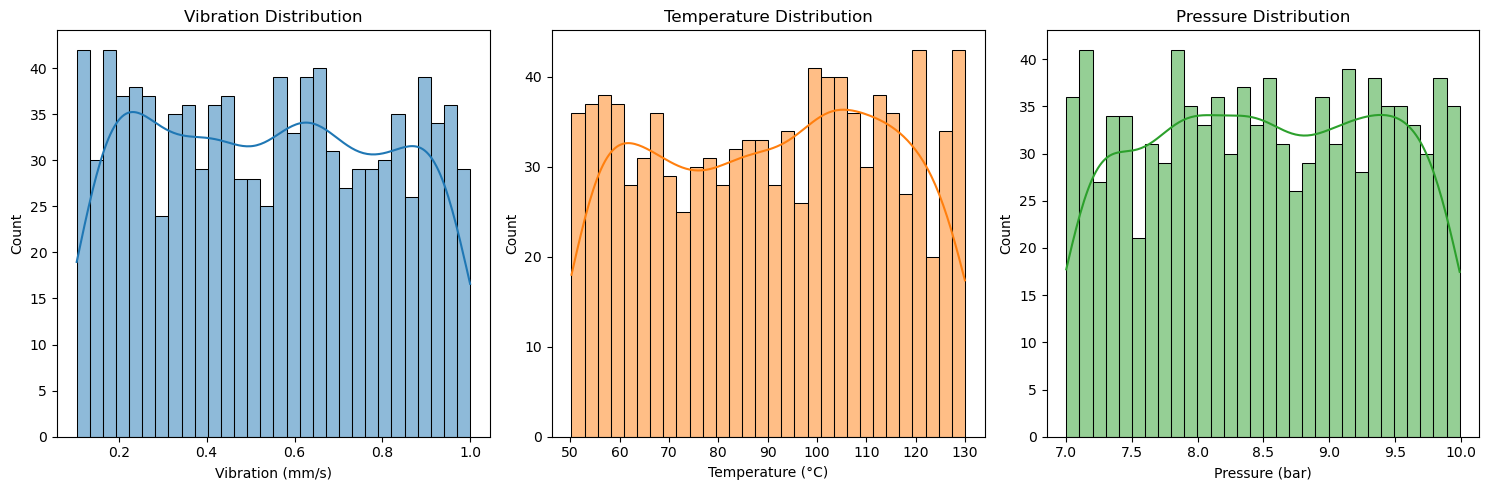

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot distributions using seaborn (plotData is not defined)
sns.histplot(df['Vibration (mm/s)'], bins=30, kde=True, ax=axes[0], color='C0')
axes[0].set_title('Vibration Distribution')
axes[0].set_xlabel('Vibration (mm/s)')

sns.histplot(df['Temperature (°C)'], bins=30, kde=True, ax=axes[1], color='C1')
axes[1].set_title('Temperature Distribution')
axes[1].set_xlabel('Temperature (°C)')

sns.histplot(df['Pressure (bar)'], bins=30, kde=True, ax=axes[2], color='C2')
axes[2].set_title('Pressure Distribution')
axes[2].set_xlabel('Pressure (bar)')

plt.tight_layout()
plt.show()
  



In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

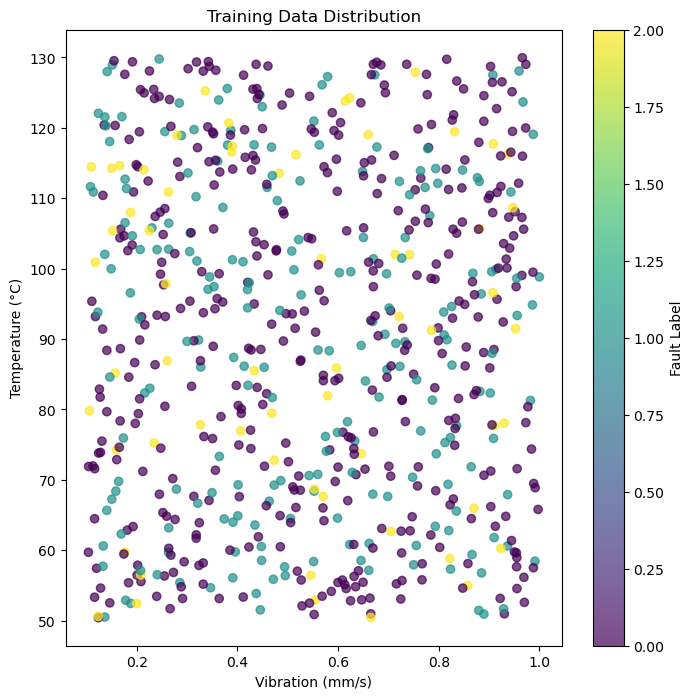

In [21]:
scaler = StandardScaler()

# X_train is a NumPy array (from earlier cells). Recreate a DataFrame with feature names for plotting.
X_train_df = pd.DataFrame(X_train, columns=Features)

fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(
	X_train_df['Vibration (mm/s)'],
	X_train_df['Temperature (°C)'],
	c=y_train,
	cmap='viridis',
	alpha=0.7
)
ax.set_xlabel('Vibration (mm/s)')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Training Data Distribution')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Fault Label')
plt.show()

In [22]:
# X_train_scaled is the standardized version of the training data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)



# **Model Creation**

Class weights: {0: np.float64(0.5477308294209703), 1: np.float64(1.10062893081761), 2: np.float64(3.763440860215054)}

LogisticRegression CV scores: {'accuracy_mean': np.float64(0.2928571428571428), 'balanced_accuracy_mean': np.float64(0.311087091962605), 'f1_macro_mean': np.float64(0.26507047012353147)}

SVC_RBF CV scores: {'accuracy_mean': np.float64(0.31999999999999995), 'balanced_accuracy_mean': np.float64(0.3490144632689093), 'f1_macro_mean': np.float64(0.2905674552960643)}

RandomForest CV scores: {'accuracy_mean': np.float64(0.54), 'balanced_accuracy_mean': np.float64(0.3116157470740234), 'f1_macro_mean': np.float64(0.2761579432351594)}

GradientBoosting CV scores: {'accuracy_mean': np.float64(0.5442857142857143), 'balanced_accuracy_mean': np.float64(0.33488215083290324), 'f1_macro_mean': np.float64(0.315894651875887)}

XGBoost CV scores: {'accuracy_mean': np.float64(0.5657142857142856), 'balanced_accuracy_mean': np.float64(0.326016312309062), 'f1_macro_mean': np.float64(0.28375

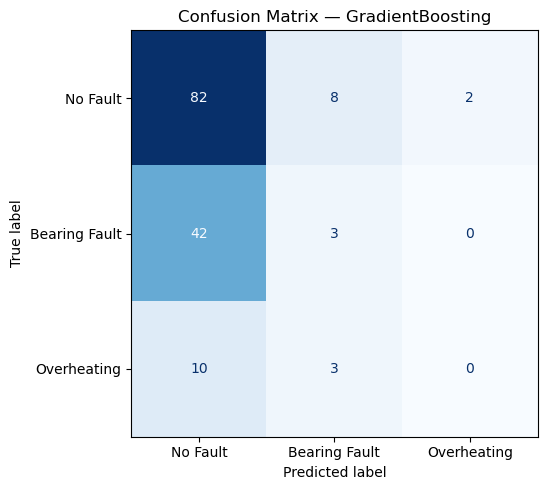

In [23]:
# === Compute class weights (optional but explicit) ===
from xgboost import XGBClassifier

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(cls): w for cls, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)
xgb_scale_pos_weight = 1
# === Define candidate models ===
models = {
    'LogisticRegression': Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            multi_class='multinomial',
            class_weight=class_weight_dict,
            max_iter=2000,
            solver='lbfgs',
            random_state=42
        ))
    ]),
    'SVC_RBF': Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('clf', SVC(
            kernel='rbf',
            class_weight=class_weight_dict,
            probability=False,  # set True if you need calibrated probabilities later
            C=1.0,
            gamma='scale',
            random_state=42
        ))
    ]),
    'RandomForest': RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight=class_weight_dict,
        n_jobs=-1,
        random_state=42
    ),
    'GradientBoosting': GradientBoostingClassifier(
        random_state=42
        # Note: no native class_weight; included for comparison
    ),
       # === NEW: XGBoost model ===
    'XGBoost': XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        n_estimators=100,        # sklearn GBDT equivalent
        learning_rate=0.1,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=1.0,
        scale_pos_weight=xgb_scale_pos_weight,
        tree_method="hist",      # faster modern default
        use_label_encoder=False
    )

}

# === Cross-validation setup ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': 'accuracy',
    'balanced_accuracy': 'balanced_accuracy',
    'f1_macro': 'f1_macro'
}

cv_results = {}

for name, model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    summary = {
        'accuracy_mean': np.mean(scores['test_accuracy']),
        'balanced_accuracy_mean': np.mean(scores['test_balanced_accuracy']),
        'f1_macro_mean': np.mean(scores['test_f1_macro'])
    }
    cv_results[name] = summary
    print(f"\n{name} CV scores: {summary}")

# === Pick best model by macro F1 ===
best_name = max(cv_results, key=lambda k: cv_results[k]['f1_macro_mean'])
best_model = models[best_name]
print(f"\nSelected best model: {best_name} (by macro F1)")

# === Fit best model on train and evaluate on test ===
if isinstance(best_model, Pipeline):
    best_model.fit(X_train, y_train)
else:
    best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("\nClassification report (test set):")
print(classification_report(y_test, y_pred, target_names=[label_mapping[i] for i in sorted(label_mapping.keys())]))

# === Confusion matrix ===
cm = confusion_matrix(y_test, y_pred, labels=sorted(label_mapping.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_mapping[i] for i in sorted(label_mapping.keys())])
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title(f'Confusion Matrix — {best_name}')
plt.tight_layout()
plt.show()

# === Feature importance (for tree or linear) ===
def plot_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        plt.figure(figsize=(7,4))
        sns.barplot(x=fi.values, y=fi.index, palette='viridis')
        plt.title('Feature importance (tree-based)')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    elif isinstance(model, Pipeline) and hasattr(model.named_steps['clf'], 'coef_'):
        # For multinomial logistic regression
        coefs = model.named_steps['clf'].coef_  # shape: (n_classes, n_features)
        coef_df = pd.DataFrame(coefs, columns=feature_names)
        coef_df.index = [label_mapping[i] for i in sorted(label_mapping.keys())]
        plt.figure(figsize=(8,5))
        sns.heatmap(coef_df, annot=True, fmt='.3f', cmap='coolwarm', cbar=True)
        plt.title('Class-wise coefficients (Logistic Regression)')
        plt.tight_layout()
        plt.show()
    else:
        print("Feature importance not available for this model.")

# Plot importance if available
if best_name == 'RandomForest':
    plot_feature_importance(best_model, features)
elif best_name == 'LogisticRegression':
    plot_feature_importance(best_model, features)

### weer | small decision tree model for feature importance visualization ###
### 

In [24]:
import nbconvert

!jupyter nbconvert --to script AML_project.ipynb


[NbConvertApp] Converting notebook AML_project.ipynb to script
[NbConvertApp] Writing 13822 bytes to AML_project.py
